In [40]:
!pip install pydantic
!pip install langchain
!pip install langgraph
!pip install langchain-core
!pip install langchain-community
!pip install langchain-groq
!pip install arxiv
!pip install wikipedia

In [41]:
from langchain_community.tools import ArxivQueryRun, WikipediaQueryRun
from langchain_community.utilities import ArxivAPIWrapper, WikipediaAPIWrapper
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_groq import ChatGroq

from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage
from typing import Annotated
from langgraph.graph.message import add_messages

from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

In [42]:
api_wrapper_arxiv = ArxivAPIWrapper(top_k_results = 2, doc_content_chars_max = 500)
arxiv = ArxivQueryRun(api_wrapper = api_wrapper_arxiv, description = "Query arxiv papers")

In [43]:
print(arxiv.invoke("Attention is all you need"))

Published: 2024-07-22
Title: Attention Is All You Need But You Don't Need All Of It For Inference of Large Language Models
Authors: Georgy Tyukin, Gbetondji J-S Dovonon, Jean Kaddour, Pasquale Minervini
Summary: The inference demand for LLMs has skyrocketed in recent months, and serving
models with low latencies remains challenging due to the quadratic input length
complexity of the attention layers. In this work, we investigate the effect of
dropping MLP and attention layers at inference time o


In [44]:
api_wrapper_wikipedia = WikipediaAPIWrapper(top_k_results = 1, doc_content_chars_max = 500)
wikipedia = WikipediaQueryRun(api_wrapper = api_wrapper_wikipedia)

In [45]:
tavily = TavilySearchResults(tavily_api_key = "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")

In [46]:
print(tavily.invoke("Provide me the recent AI news"))

[{'title': 'Latest AI News and Technology Developments – September 2025', 'url': 'http://rapidassure.com/breaking-latest-ai-news-and-technology-developments-september-2025/', 'content': '### Breaking: Latest AI News and Technology Developments – September 2025\n\nThe artificial intelligence landscape continues to evolve at a breakneck pace, with significant developments reshaping how we interact with AI systems and their applications across industries. Here are the most important AI news stories and technological breakthroughs as of September 2025.\n\n## Apple’s Strategic AI Push: Siri Gets Major Intelligence Upgrade [...] ## Infrastructure Investment: Massive AI Data Center Development\n\nThe AI boom is driving substantial infrastructure investments, with a massive $3 billion AI-focused data center set to be built in Harwood, North Dakota. The facility will include advanced infrastructure for AI training and cloud services. This development reflects the enormous computational requirem

In [47]:
tools = [arxiv, wikipedia, tavily]

In [48]:
llm = ChatGroq(
    model = "qwen/qwen3-32b",
    groq_api_key = "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"
)

In [49]:
res = llm.invoke("سلام، خوبی؟")
print(res.content)

<think>
Alright, the user greeted me with "سلام، خوبی؟" which means "Hello, are you okay?" in Persian. I need to respond politely. Since I'm an AI, I can't feel emotions, but I should acknowledge their greeting and offer help. Let me make sure the response is friendly and in Persian. Something like "سلام! من یک ماشین حساب هوشمند هستم. چطور می‌تونم کمکتون کنم؟" That should work. It greets them back, states my role, and asks how I can assist.
</think>

سلام! من یک ماشین حساب هوشمند هستم. چطور می‌تونم کمکتون کنم؟


In [50]:
llm_with_tools = llm.bind_tools(tools = tools)

In [51]:
llm_with_tools.invoke("What is the recent news on AI?")

AIMessage(content='', additional_kwargs={'reasoning_content': 'Okay, the user is asking for recent news on AI. I need to figure out which tool to use here. Let me check the available tools. There\'s arxiv, wikipedia, and tavily_search_results_json. \n\nArxiv is for academic papers, so maybe not the best choice for general news. Wikipedia is good for general knowledge but might not have the latest updates. The third one, tavily_search_results_json, is described as a search engine optimized for current events. That sounds perfect for recent news.\n\nSo I should use tavily_search_results_json with the query "recent news on AI". Let me make sure the parameters are correct. The function requires a query string. The user\'s question is straightforward, so the query should be clear. I\'ll format the tool call accordingly.\n', 'tool_calls': [{'id': 'rm28j0v26', 'function': {'arguments': '{"query":"recent news on AI"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_meta

In [52]:
llm_with_tools.invoke("What is the latest research on quantum computing?")

AIMessage(content='', additional_kwargs={'reasoning_content': 'Okay, the user is asking about the latest research on quantum computing. I need to figure out which tool to use here. Let me look at the available functions.\n\nFirst, there\'s the arxiv function, which is for querying arxiv papers. Since arxiv is a repository for preprints in physics, math, and computer science, that\'s probably the best place to find the latest research papers. The user wants the "latest" research, so arxiv would be ideal because it\'s where researchers often publish their latest findings before they appear in journals.\n\nThe other options are Wikipedia and Tavily search. Wikipedia is good for general knowledge and background info but might not have the most up-to-date cutting-edge research. Tavily is a search engine for current events, but since quantum computing research is often published on arxiv first, I think arxiv is more direct here.\n\nSo I should use the arxiv function with a query related to q

In [53]:
llm_with_tools.invoke("What is machine learning?")

AIMessage(content='', additional_kwargs={'reasoning_content': 'Okay, the user is asking "What is machine learning?" I need to provide a clear and concise answer. Let me start by recalling the basic definition. Machine learning is a subset of artificial intelligence that involves systems learning from data. But maybe I should check a reliable source to ensure accuracy.\n\nI can use the Wikipedia function to get a general overview. Let me call the wikipedia function with the query "Machine learning". That should give me a solid foundation. Also, maybe the Tavily search could help if there\'s need for more current information, but since the question is fundamental, Wikipedia might suffice. I don\'t think arXiv is necessary here because it\'s more about research papers, and the user might not need that level of detail unless they ask for recent studies. So, I\'ll proceed with the Wikipedia function first.\n', 'tool_calls': [{'id': '7by908f17', 'function': {'arguments': '{"query":"Machine l

In [54]:
class State(TypedDict):
  messages: Annotated[list[AnyMessage], add_messages]

In [55]:
def tool_calling_llm(state: State):
  return {"messages": [llm_with_tools.invoke(state["messages"])]}

In [56]:
builder = StateGraph(State)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode(tools))

In [57]:
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges("tool_calling_llm", tools_condition)
builder.add_edge("tools", END)

In [58]:
graph = builder.compile()

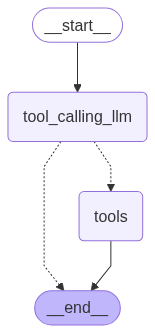

In [59]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [60]:
messages = graph.invoke({"messages": "1706.03762"})
for m in messages["messages"]:
  m.pretty_print()

================================ Human Message =================================

1706.03762
================================== Ai Message ==================================
Tool Calls:
  arxiv (bgwcwmhj6)
 Call ID: bgwcwmhj6
  Args:
    query: 1706.03762
================================= Tool Message =================================
Name: arxiv

Published: 2023-08-02
Title: Attention Is All You Need
Authors: Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N. Gomez, Lukasz Kaiser, Illia Polosukhin
Summary: The dominant sequence transduction models are based on complex recurrent or
convolutional neural networks in an encoder-decoder configuration. The best
performing models also connect the encoder and decoder through an attention
mechanism. We propose a new simple network architecture, the Transformer, base


In [61]:
messages = graph.invoke({"messages": "Hi, my name is ali"})
for m in messages["messages"]:
  m.pretty_print()

================================ Human Message =================================

Hi, my name is ali
================================== Ai Message ==================================

Hello, Ali! How can I assist you today?


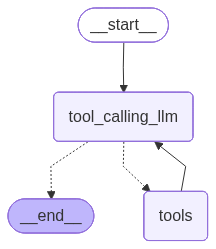

In [62]:
def tool_calling_llm(state: State):
  return {"messages": [llm_with_tools.invoke(state["messages"])]}

builder = StateGraph(State)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges("tool_calling_llm", tools_condition)
builder.add_edge("tools", "tool_calling_llm")

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [63]:
2+2

4

In [65]:
messages = graph.invoke({"messages": "What is the recent AI news and please tell me the recent research paper on quantum computing?"})
for m in messages["messages"]:
  m.pretty_print()

================================ Human Message =================================

What is the recent AI news and please tell me the recent research paper on quantum computing?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (2f4asxnwv)
 Call ID: 2f4asxnwv
  Args:
    query: latest AI news 2024
  arxiv (305e5wapd)
 Call ID: 305e5wapd
  Args:
    query: quantum computing sort: date
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "2024: A year of extraordinary progress and advancement in AI", "url": "https://blog.google/technology/ai/2024-ai-extraordinary-progress-advancement/", "content": "This article summarizes Google's AI advancements in 2024, highlighting their commitment to responsible development.\n Google released Gemini 2.0, a powerful AI model designed for the \"agentic era,\" and integrated it into various products.\n They made 